# 미션 6 개요
흉부 X-Ray 사진을 바탕으로 폐렴 환자를 구분하는 작업을 수행.

X-Ray 사진을 입력으로 받아 폐렴 여부를 구분하는 분류(Classsification) 모델을 만드는 것.

다양한 이미지 전처리 및 증강 기법과 Transfer Learning과 Fine-Tuning 기법을 실험해보고, 모델의 성능을 평가.

데이터
 - Chest X-Ray Images(Pneumonia)
     - train : 훈련 데이터
     - val : 검증 데이터
     - test : 테스트 데이터

- Transfer Learning 적용
- Fine-Tuning 적용
   - Frozen 모델, Partial Fine-Tuning, Full Fine-Tuning 비교/실험
   - 모델별 성능 비교, 분석 결과 도출
- 모델 성능 평가
   - 평가 지표(Accuracy, Precision, Recall, F1-score 등) 활용 모델 성능 분석 비교

# 환경설정

In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2

from pathlib import Path
import kagglehub

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchvision.models as models
from torchvision import models
from torchinfo import summary

from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.v2 as v2
import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import copy

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from datetime import datetime
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

In [2]:
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

os.makedirs("pth", exist_ok=True)

PyTorch: 2.7.1
MPS available: True
mps


## 함수화

https://en.wikipedia.org/wiki/Early_stopping

In [3]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0.0, restore_best_weights=True, verbose=True):
        self.patience = patience
        self.delta = delta  
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False
        self.best_model_path = None

    def __call__(self, val_loss, model, epoch, model_name, loss_name, val_accuracy, val_f1):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_weights = copy.deepcopy(model.state_dict())
            # 첫 번째 저장
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            self.best_model_path = f"./pth/{model_name}_{loss_name}_{ts}_best_epoch{epoch:03d}_val{val_loss:.6f}_acc{val_accuracy:.4f}_f1{val_f1:.4f}.pth"
            torch.save(self.best_weights, self.best_model_path)
            if self.verbose:
                print(f"↳ New best model saved: {self.best_model_path}")
        elif val_loss < self.best_loss - self.delta: 
            self.best_loss = val_loss
            self.counter = 0
            self.best_weights = copy.deepcopy(model.state_dict())
            # 더 좋은 모델 저장
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            self.best_model_path = f"./pth/{model_name}_{loss_name}_{ts}_best_epoch{epoch:03d}_val{val_loss:.6f}_acc{val_accuracy:.4f}_f1{val_f1:.4f}.pth"
            torch.save(self.best_weights, self.best_model_path)
            if self.verbose:
                print(f"↳ New best model saved: {self.best_model_path}")
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            if self.verbose:
                print(f"Early stopping triggered at epoch {epoch}")
            return True
        return False

In [5]:
def train_model(model, loss_fn, optimizer, train_loader, val_loader, device, num_epochs=100, model_name="model", patience=5, delta=0.0, verbose=True):
    history = {'train_loss':[], 'val_loss': [], 'val_accuracy': [], 'val_f1': []}
    loss_name = loss_fn.__class__.__name__
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # EarlyStopping 초기화 (path는 나중에 설정)
    early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=verbose)

    for epoch in range(num_epochs):
        # training
        model.train()
        running_loss = 0.0
        for step, (X, y) in enumerate(train_loader, 1):
            X, y = X.to(device), y.to(device)

            preds = model(X)
            loss = loss_fn(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if step % 50 == 0:
                print(f"[{model_name}] Epoch {epoch} step {step} train_loss = {loss.item():.6f}")

        avg_train_loss = running_loss / len(train_loader)
        
        # validation
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = loss_fn(preds, y)
                val_losses.append(loss.item())

                # accuracy 계산
                _, predicted = torch.max(preds, 1)
                val_correct += (predicted == y).sum().item()
                val_total += y.size(0)

                # F1 score 계산
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        val_accuracy = val_correct / val_total
        avg_val_loss = sum(val_losses) / len(val_losses)

        # F1 score 계산
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        history['train_loss'].append(avg_train_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(val_f1)

        print(f"[{model_name}] Epoch {epoch} train_loss = {avg_train_loss:.6f} val_loss={avg_val_loss:.6f} val_accuracy={val_accuracy:.6f} val_f1={val_f1:.6f}")

        # EarlyStopping 체크 (모든 지표 전달)
        early_stopping(avg_val_loss, model, epoch, model_name, loss_name, val_accuracy, val_f1)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break

    # 학습 종료 후 best model 불러오기
    if early_stopping.best_model_path is not None:
        model.load_state_dict(torch.load(early_stopping.best_model_path))
    return history

## 데이터 불러오기

In [6]:
# KaggleHub 캐시를 현재 노트북 폴더 안에 .kagglehub_cache 로 고정
cache_dir = Path.cwd() / ".kagglehub_cache"
cache_dir.mkdir(parents=True, exist_ok=True)
os.environ["KAGGLEHUB_CACHE"] = str(cache_dir)

print(cache_dir)

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)


/Users/leeyoungho/develop/ai_study/mission/mission6/.kagglehub_cache
Path to dataset files: /Users/leeyoungho/develop/ai_study/mission/mission6/.kagglehub_cache/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [7]:
# 폴더 경로 설정
train_dir = os.path.join(path, "chest_xray", "train")
val_dir = os.path.join(path, "chest_xray", "val")
test_dir = os.path.join(path, "chest_xray", "test")

## Case 1

### transform 만들기

In [34]:
crop_h, crop_w = 224, 224 #ResNet18 기본 이미지 크기

# 데이터 전처리 정의
data_transforms = {
    'train': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.RandomCrop((200, 200)),          # 랜덤 크롭 (200x200)
        v2.RandomRotation(20),              # 랜덤 회전 (-20도 ~ 20도)
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ]),
    'val': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ]),
    'test': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ])
}


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### dataset 만들기

In [35]:
# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

In [51]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 5216
Validation dataset size: 16
Test dataset size: 624


### dataloader 만들기

In [36]:
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 클래스 확인
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


# 모델

## Pretrained 모델 사용

In [37]:
pretrained_model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

In [38]:
summary(pretrained_model, (1, 3, 224, 224), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

## features freeze, classifier 교체

### 1. 분류기 교체 (2클래스)

In [39]:
num_ftrs = pretrained_model.fc.in_features  # ImageNet용 ResNet18은 nn.Linear(512, 1000) 구조 -> num_ftrs = 512
pretrained_model.fc = nn.Linear(num_ftrs, 2)  # 클래스 수 = 2 (NORMAL, PNEUMONIA) # 마지막 FC layer를 512->2로 변경
pretrained_model = pretrained_model.to(device)


### 2. features freeze (가중치 고정)

In [22]:
for param in pretrained_model.parameters():
    param.requires_grad = False  # 모든 파라미터 freeze

for param in pretrained_model.fc.parameters():
    param.requires_grad = True   # 분류기만 학습

In [40]:
for param in pretrained_model.parameters():
    param.requires_grad = False  # 모든 파라미터 freeze

for param in pretrained_model.layer4.parameters(): # 마지막 conv layer만 unfreeze
    param.requires_grad = True
for param in pretrained_model.fc.parameters():
    param.requires_grad = True   # 분류기만 학습

### 3. 손실함수, 옵티마이저 정의

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.fc.parameters(), lr=1e-3)

### 4. train

In [44]:
history = train_model(
    pretrained_model,           
    criterion,                  # 손실 함수
    optimizer,                  # 옵티마이저
    train_loader,               
    val_loader,                 
    device,                     
    num_epochs=100,              
    model_name="resnet18_freeze", 
    patience=5,                  
    delta=0.0005,
)

[resnet18_freeze] Epoch 0 step 50 train_loss = 0.284932
[resnet18_freeze] Epoch 0 step 100 train_loss = 0.333405
[resnet18_freeze] Epoch 0 step 150 train_loss = 0.311699
[resnet18_freeze] Epoch 0 train_loss = 0.251450 val_loss=0.443113 val_accuracy=0.750000 val_f1=0.733333
↳ New best model saved: ./pth/resnet18_freeze_CrossEntropyLoss_20250626_100314_best_epoch000_val0.443113_acc0.7500_f10.7333.pth
[resnet18_freeze] Epoch 1 step 50 train_loss = 0.177839
[resnet18_freeze] Epoch 1 step 100 train_loss = 0.322668
[resnet18_freeze] Epoch 1 step 150 train_loss = 0.099412
[resnet18_freeze] Epoch 1 train_loss = 0.211262 val_loss=0.698134 val_accuracy=0.750000 val_f1=0.733333
[resnet18_freeze] Epoch 2 step 50 train_loss = 0.118731
[resnet18_freeze] Epoch 2 step 100 train_loss = 0.340931
[resnet18_freeze] Epoch 2 step 150 train_loss = 0.270912
[resnet18_freeze] Epoch 2 train_loss = 0.210881 val_loss=0.443550 val_accuracy=0.750000 val_f1=0.733333
[resnet18_freeze] Epoch 3 step 50 train_loss = 0.1

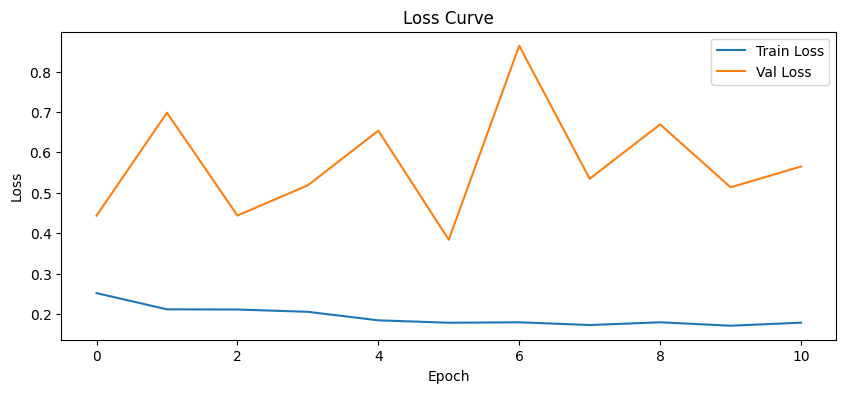

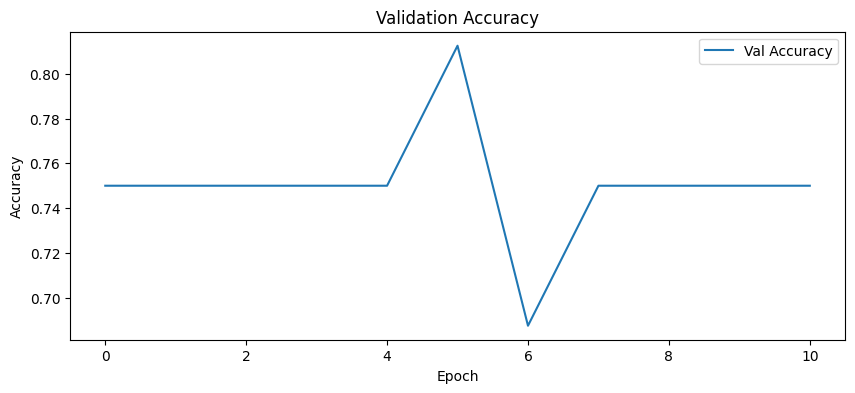

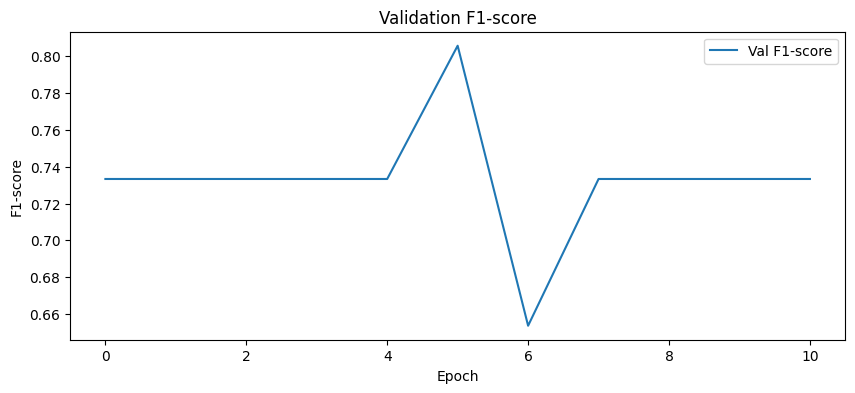

In [46]:
# 1. Loss 그래프
plt.figure(figsize=(10,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 2. Accuracy 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 3. F1-score 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_f1'], label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score')
plt.legend()
plt.show()

### 훈련 결과

1. Loss (Train / Val)
    - Train loss 는 꾸준히 감소(0.25 → 0.17)하며, 안정적
    - Vall loss는 진동이 심하고, 에폭마다 크게 변동 (0.38 → 0.86)

    🤔유추 가능한 원인
      - 검증 데이터셋이 작다 (16개), 클래스 불균형, 데이터 다양성 부족, 증강 부족
      - 모델이 validation set에 적합하지 않고, 불안정

    ➡️ 해석
    - 모델이 train data에는 잘 적응하지만, val data에는 일관성있게 일반화하지 못하고 있음.
    - 과적합은 심하지 않으나, 일반화 성능이 불안정함.

2. Validation Accuracy & F1-score
   - 대부분 0.75에서 고정. (0.81 상승, 0.69 하락)
   - 모델이 validation set의 일부 샘플에 민감하게 반응.
   - 성능 정체 상태.

In [48]:
pretrained_model_finetunebest_load = pretrained_model.to(device)
pretrained_model_finetunebest_load.load_state_dict(torch.load('pth/resnet18_freeze_CrossEntropyLoss_20250626_100835_best_epoch005_val0.383615_acc0.8125_f10.8057.pth', map_location=device))
pretrained_model_finetunebest_load.to(device)
pretrained_model_finetunebest_load.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = pretrained_model_finetunebest_load(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 3. 지표 계산
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.8606
Test F1-score: 0.8559
Confusion Matrix:
[[163  71]
 [ 16 374]]


### Test 결과
- Test Accuray : 0.8606 (86%)
- Test F1-score : 0.8559

- confusion Matrix
    - TN(정상-정상) : 163
    - FP(정상-페렴) : 71
    - FN(폐렴-정상) : 16
    - TP(페렴-폐렴) : 374

➡️ 해석
- 폐렴 환자(양성) 검출은 매우 잘함 (FN=16, TP=274 → 재현율 높음)
- 정상 환자(음성)에서 오분류가 많음 (FP=71, TN=163 → 정밀도 낮음)
- 양성 과탐지 / 음성 누락
- 실제 의료 현장에서는 폐렴을 놓치지 않는 것이 더 중요하므로, 이 결과는 실용적일 수 있음.

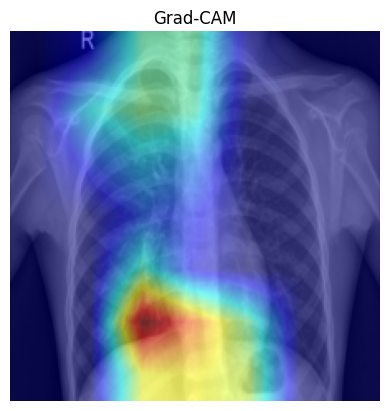

In [50]:
# 1. 모델 준비 (이미 학습된 모델 불러오기)
pretrained_model_finetunebest_load.eval()

# 2. Grad-CAM 객체 생성 (마지막 conv layer 지정)
target_layer = pretrained_model_finetunebest_load.layer4[-1]  # ResNet18의 마지막 conv block
cam = GradCAM(model=pretrained_model_finetunebest_load, target_layers=[target_layer])

# 3. 테스트 이미지 1장 불러오기
img_tensor, label = test_dataset[0]  # (C, H, W), torch.Tensor
input_tensor = img_tensor.unsqueeze(0).to(device)  # 배치 차원 추가

# 4. CAM 생성
grayscale_cam = cam(input_tensor=input_tensor)[0]  # (H, W), numpy

# 5. 원본 이미지로 변환
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # 0~1 정규화

# 6. CAM 시각화
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

## Case2

todo
- 데이터
    1. 데이터 증강 ✅
    2. WeightedRandomSampler 만 ✅
    3. loss function에 class weight 적용 만 ❌
    4. 2와 3 동시 ❌
- 훈련
    1. Stratified K-Fold Cross Validation ❌

### transform 만들기

데이터 증강

In [8]:
crop_h, crop_w = 224, 224 #ResNet18 기본 이미지 크기

# 데이터 전처리 정의
data_transforms_v2 = {
    'train': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.RandomHorizontalFlip(),
        v2.RandomCrop((200, 200)),          # 랜덤 크롭 (200x200)
        v2.RandomRotation(20),              # 랜덤 회전 (-20도 ~ 20도)
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ]),
    'val': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ]),
    'test': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ])
}

/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### dataset 만들기

In [9]:
# 데이터셋 로드
train_dataset_v2 = datasets.ImageFolder(train_dir, transform=data_transforms_v2['train'])
val_dataset_v2 = datasets.ImageFolder(val_dir, transform=data_transforms_v2['val'])
test_dataset_v2 = datasets.ImageFolder(test_dir, transform=data_transforms_v2['test'])

In [10]:
print(f"Train dataset size: {len(train_dataset_v2)}")
print(f"Validation dataset size: {len(val_dataset_v2)}")
print(f"Test dataset size: {len(test_dataset_v2)}")

Train dataset size: 5216
Validation dataset size: 16
Test dataset size: 624


WeightedRandomSampler로 클래스 불균형 완화하기

https://medium.com/data-science/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452

In [11]:
class_counts = Counter(train_dataset_v2.targets)
print(class_counts)

Counter({1: 3875, 0: 1341})


In [12]:
num_samples = len(train_dataset_v2)
class_sample_count = np.array([class_counts[i] for i in range(len(class_counts))])
weight = 1. / class_sample_count
samples_weight = np.array([weight[i] for i in train_dataset_v2.targets])

print(f"class_sample_count : {class_sample_count}")
print(f"samples_weight : {samples_weight}")

class_sample_count : [1341 3875]
samples_weight : [0.00074571 0.00074571 0.00074571 ... 0.00025806 0.00025806 0.00025806]


In [13]:
samples_weight = torch.from_numpy(samples_weight).float()
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

### dataloader 만들기

In [15]:
# DataLoader 생성
train_loader_v2 = DataLoader(train_dataset_v2, batch_size=32, sampler=sampler, num_workers=2, shuffle=False)
val_loader_v2 = DataLoader(val_dataset_v2, batch_size=32, num_workers=2, shuffle=False)
test_loader_v2 = DataLoader(test_dataset_v2, batch_size=32, num_workers=2, shuffle=False)


### 모델

In [16]:
pretrained_model_v2 = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

In [17]:
summary(pretrained_model_v2, (1, 3, 224, 224), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

### features freeze, classifier 교체

### 1. 분류기 교체 (2클래스)

In [18]:
num_ftrs = pretrained_model_v2.fc.in_features  # ImageNet용 ResNet18은 nn.Linear(512, 1000) 구조 -> num_ftrs = 512
pretrained_model_v2.fc = nn.Linear(num_ftrs, 2)  # 클래스 수 = 2 (NORMAL, PNEUMONIA) # 마지막 FC layer를 512->2로 변경
pretrained_model_v2 = pretrained_model_v2.to(device)

### 2. features freeze (가중치 고정)

In [19]:
for param in pretrained_model_v2.parameters():
    param.requires_grad = False  # 모든 파라미터 freeze

for param in pretrained_model_v2.layer4.parameters(): # 마지막 conv layer만 unfreeze
    param.requires_grad = True
for param in pretrained_model_v2.fc.parameters():
    param.requires_grad = True   # 분류기만 학습

### 3. 손실함수, 옵티마이저 정의

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model_v2.fc.parameters(), lr=1e-3)

### 4. train

In [24]:
history = train_model(
    pretrained_model_v2,           
    criterion,                  # 손실 함수
    optimizer,                  # 옵티마이저
    train_loader_v2,               
    val_loader_v2,                 
    device,                     
    num_epochs=100,              
    model_name="resnet18_freeze", 
    patience=12,                  
    delta=0.0005,
)

[resnet18_freeze] Epoch 0 step 50 train_loss = 0.185696
[resnet18_freeze] Epoch 0 step 100 train_loss = 0.213204
[resnet18_freeze] Epoch 0 step 150 train_loss = 0.318011
[resnet18_freeze] Epoch 0 train_loss = 0.235944 val_loss=0.328654 val_accuracy=0.812500 val_f1=0.805668
↳ New best model saved: ./pth/resnet18_freeze_CrossEntropyLoss_20250626_122015_best_epoch000_val0.328654_acc0.8125_f10.8057.pth
[resnet18_freeze] Epoch 1 step 50 train_loss = 0.209639
[resnet18_freeze] Epoch 1 step 100 train_loss = 0.190307
[resnet18_freeze] Epoch 1 step 150 train_loss = 0.209228
[resnet18_freeze] Epoch 1 train_loss = 0.233985 val_loss=0.278420 val_accuracy=0.875000 val_f1=0.873016
↳ New best model saved: ./pth/resnet18_freeze_CrossEntropyLoss_20250626_122104_best_epoch001_val0.278420_acc0.8750_f10.8730.pth
[resnet18_freeze] Epoch 2 step 50 train_loss = 0.170810
[resnet18_freeze] Epoch 2 step 100 train_loss = 0.116559
[resnet18_freeze] Epoch 2 step 150 train_loss = 0.325224
[resnet18_freeze] Epoch 2 

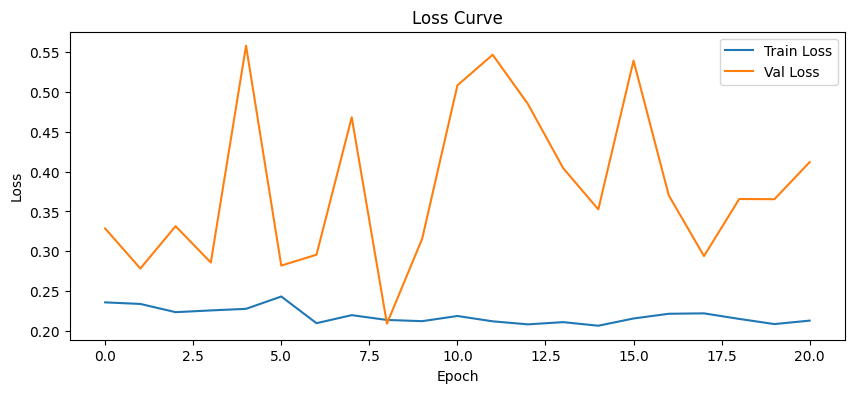

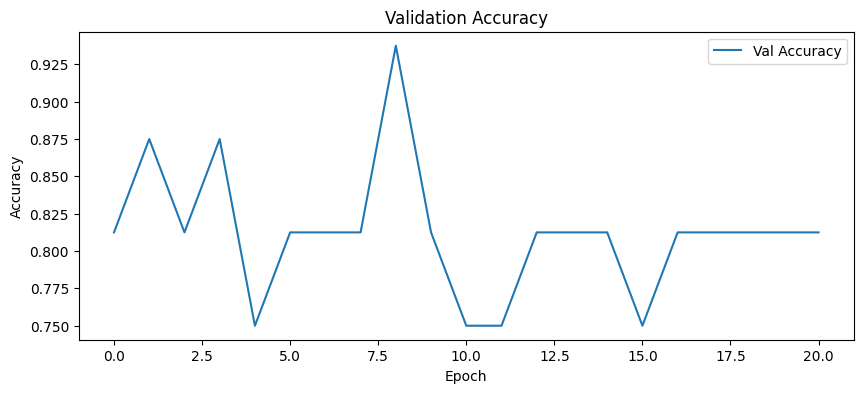

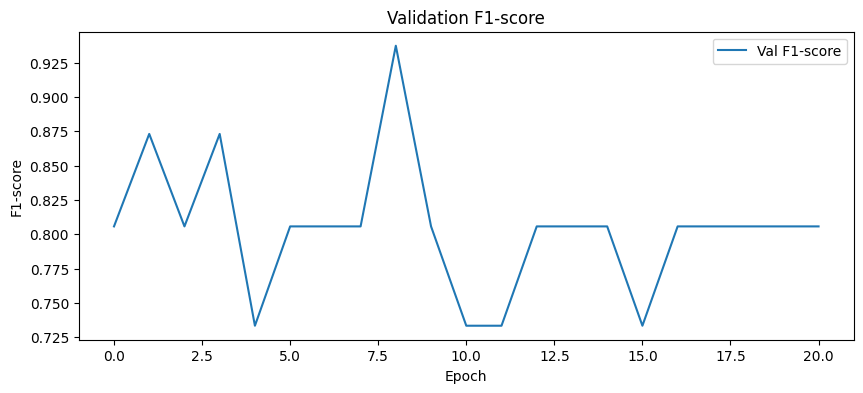

In [25]:
# 1. Loss 그래프
plt.figure(figsize=(10,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 2. Accuracy 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 3. F1-score 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_f1'], label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score')
plt.legend()
plt.show()

In [26]:
pretrained_model_v2_finetunebest_load = pretrained_model_v2.to(device)
pretrained_model_v2_finetunebest_load.load_state_dict(torch.load('pth/resnet18_freeze_CrossEntropyLoss_20250626_122652_best_epoch008_val0.209221_acc0.9375_f10.9373.pth', map_location=device))
pretrained_model_v2_finetunebest_load.to(device)
pretrained_model_v2_finetunebest_load.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader_v2:
        X, y = X.to(device), y.to(device)
        outputs = pretrained_model_v2_finetunebest_load(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 3. 지표 계산
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.8766
Test F1-score: 0.8762
Confusion Matrix:
[[192  42]
 [ 35 355]]


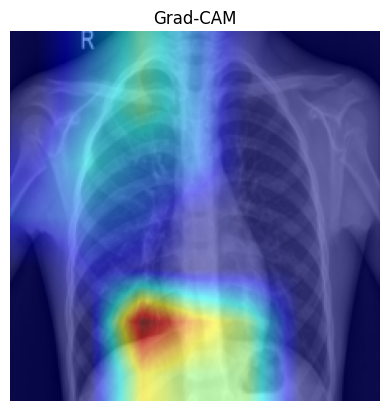

In [29]:
# 1. 모델 준비 (이미 학습된 모델 불러오기)
pretrained_model_v2_finetunebest_load.eval()

# 2. Grad-CAM 객체 생성 (마지막 conv layer 지정)
target_layer = pretrained_model_v2_finetunebest_load.layer4[-1]  # ResNet18의 마지막 conv block
cam = GradCAM(model=pretrained_model_v2_finetunebest_load, target_layers=[target_layer])

# 3. 테스트 이미지 1장 불러오기
img_tensor, label = test_dataset_v2[0]  # (C, H, W), torch.Tensor
input_tensor = img_tensor.unsqueeze(0).to(device)  # 배치 차원 추가

# 4. CAM 생성
grayscale_cam = cam(input_tensor=input_tensor)[0]  # (H, W), numpy

# 5. 원본 이미지로 변환
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # 0~1 정규화

# 6. CAM 시각화
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

1. 실험 환경 요약

데이터셋
- Train: 5,216 (정상 1,341, 폐렴 3,875, 불균형 심함)
- Val: 16 (매우 적음)
- Test: 624

데이터 증강: train에만 다양한 augmentation 적용

샘플링:
- WeightedRandomSampler로 학습 배치의 클래스 균형 맞춤
- class_weight 미적용 (손실함수는 기본 CrossEntropyLoss)

모델: ResNet18, feature freeze, 마지막 conv layer와 fc만 학습

Optimizer: Adam (fc 파라미터만)

Early Stopping: patience=12, delta=0.0005

에폭: 20에서 조기 종료

2. 학습/검증 로그 및 그래프 분석

(1) Loss Courve
- Train Loss : 0.21~0.24로 매우 안정적, 과적합 없음
- Val Loss : 0.21~0.55로 진동, 에폭별 등락이 큼
    - 원인:
        - 검증 데이터 셋이 16개로 매우 작음. -> 한두 샘플에 따라 loss가 크게 변동
        - 데이터 다양성 부족 -> fold 사용 검토 고려

(2) Validation Accuracy & F1-score
- Accuracy/F1-score 0.75~0.94, 대부분 0.81~0.87
- 성능 정체.
- Accuracy/F1-score가 거의 동일 -> 클래스 불균형이 심하지만, 샘플러로 어느정도 보정

(3) Test 결과
- Test Accuracy: 0.8766
- Test F1-score: 0.8762
- Confusion Matrix:
    - TN(정상-정상) : 192
    - FP(정상-페렴) : 42
    - FN(폐렴-정상) : 35
    - TP(페렴-폐렴) : 355

➡️ 폐렴을 정상으로 분류가 35건이다.

3. 개선 제안

(1) Stratified K-Fold Cross Validation

(2) class_weight 적용 (FN을 더 줄일 수 있을지)

(3) 데이터 증강 다양화

## Case 3

todo
- 데이터
    1. 데이터 증강 ✅
- 훈련
    1. Stratified K-Fold Cross Validation ✅

### transform 만들기

데이터 증강

In [8]:
crop_h, crop_w = 224, 224 #ResNet18 기본 이미지 크기

# 데이터 전처리 정의
data_transforms_v3 = {
    'train': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.RandomHorizontalFlip(),
        v2.RandomCrop((200, 200)),          # 랜덤 크롭 (200x200)
        v2.RandomRotation(20),              # 랜덤 회전 (-20도 ~ 20도)
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ]),
    'val': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ]),
    'test': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ])
}

/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### dataset 만들기

In [9]:
# 데이터셋 로드
train_dataset_v3 = datasets.ImageFolder(train_dir, transform=data_transforms_v3['train'])
val_dataset_v3 = datasets.ImageFolder(val_dir, transform=data_transforms_v3['val'])
test_dataset_v3 = datasets.ImageFolder(test_dir, transform=data_transforms_v3['test'])

In [10]:
print(f"Train dataset size: {len(train_dataset_v3)}")
print(f"Validation dataset size: {len(val_dataset_v3)}")
print(f"Test dataset size: {len(test_dataset_v3)}")

Train dataset size: 5216
Validation dataset size: 16
Test dataset size: 624


In [23]:
test_loader_v3 = DataLoader(test_dataset_v3, batch_size=32, num_workers=2, shuffle=False)

Stratified K-Fold

In [11]:
labels = train_dataset_v3.targets
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [13]:
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"Fold {fold+1} / {n_splits} :: train_idx: {len(train_idx)}, val_idx: {len(val_idx)}")
    print(f"Fold {fold+1} / {n_splits} :: train_idx: {train_idx[:5]}, val_idx: {val_idx[:5]}")
    print(f"Fold {fold+1} / {n_splits} :: train_idx: {train_idx[-5:]}, val_idx: {val_idx[-5:]}")
    print(f"Fold {fold+1} / {n_splits} :: train_idx: {train_idx}, val_idx: {val_idx}")
    print(f"Fold {fold+1} / {n_splits} :: train_idx: {train_idx}, val_idx: {val_idx}")

    break

Fold 1 / 5 :: train_idx: 4172, val_idx: 1044
Fold 1 / 5 :: train_idx: [0 1 2 3 5], val_idx: [ 4 12 13 23 39]
Fold 1 / 5 :: train_idx: [5208 5209 5210 5213 5214], val_idx: [5195 5203 5211 5212 5215]
Fold 1 / 5 :: train_idx: [   0    1    2 ... 5210 5213 5214], val_idx: [   4   12   13 ... 5211 5212 5215]
Fold 1 / 5 :: train_idx: [   0    1    2 ... 5210 5213 5214], val_idx: [   4   12   13 ... 5211 5212 5215]


In [16]:
class make_data_loader:
    def __init__(self, train_idx, val_idx, train_dataset, val_dataset, batch_size=32, num_workers=2):
        self.train_idx = train_idx
        self.val_idx = val_idx
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers

    def get_train_loader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    
    def get_val_loader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
    

In [17]:
class make_resnet18_classifier:
    def __init__(self, num_classes=2, freeze_features=True, device='cpu', weights='ResNet18_Weights.IMAGENET1K_V1'):
        self.weights = weights
        self.num_classes = num_classes
        self.device = device

        self.pretrained_model = models.resnet18(weights=self.weights)
        num_ftrs = self.pretrained_model.fc.in_features
        self.pretrained_model.fc = nn.Linear(num_ftrs, self.num_classes)
        self.pretrained_model = self.pretrained_model.to(self.device)

        # feature freeze
        if freeze_features:
            for param in self.pretrained_model.parameters():
                param.requires_grad = False
            for param in self.pretrained_model.layer4.parameters():
                param.requires_grad = True
            for param in self.pretrained_model.fc.parameters():
                param.requires_grad = True

    def get_model(self):
        return self.pretrained_model
    
    def get_num_classes(self):
        return self.num_classes

In [18]:
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"Fold {fold+1} / {n_splits}")
    
    # Subset으로 fold별 데이터셋 생성
    train_subset = Subset(train_dataset_v3, train_idx)
    val_subset = Subset(train_dataset_v3, val_idx)

    # 클래스 분포 확인 (선택)
    train_targets = [labels[i] for i in train_idx]
    val_targets = [labels[i] for i in val_idx]
    print("Train 분포:", Counter(train_targets))
    print("Val 분포:", Counter(val_targets))

    # DataLoader 생성 (샘플러 없이 shuffle만 사용)
    data_loader_builder = make_data_loader(train_idx, val_idx, train_subset, val_subset, batch_size=32, num_workers=2)
    train_loader_v3 = data_loader_builder.get_train_loader()
    val_loader_v3 = data_loader_builder.get_val_loader()

    # 모델, optimizer, criterion 등 fold마다 새로 생성

    model_builder = make_resnet18_classifier(num_classes=2, freeze_features=True, device=device)
    model_v3 = model_builder.get_model()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_v3.fc.parameters(), lr=1e-3)

    # 학습
    history = train_model(
        model_v3,                    
        criterion,                  # 손실 함수
        optimizer,                  # 옵티마이저
        train_loader_v3,               
        val_loader_v3,                 
        device,                     
        num_epochs=100,             
        model_name=f"resnet18_fold{fold+1}",
        patience=12,                  # 조기 종료 파라미터
        delta=0.0005,
    )


Fold 1 / 5
Train 분포: Counter({1: 3100, 0: 1072})
Val 분포: Counter({1: 775, 0: 269})
[resnet18_fold1] Epoch 0 step 50 train_loss = 0.492656
[resnet18_fold1] Epoch 0 step 100 train_loss = 0.417353
[resnet18_fold1] Epoch 0 train_loss = 0.377782 val_loss=0.290073 val_accuracy=0.863985 val_f1=0.854898
↳ New best model saved: ./pth/resnet18_fold1_CrossEntropyLoss_20250626_151531_best_epoch000_val0.290073_acc0.8640_f10.8549.pth
[resnet18_fold1] Epoch 1 step 50 train_loss = 0.302961
[resnet18_fold1] Epoch 1 step 100 train_loss = 0.194919
[resnet18_fold1] Epoch 1 train_loss = 0.267877 val_loss=0.257487 val_accuracy=0.879310 val_f1=0.869458
↳ New best model saved: ./pth/resnet18_fold1_CrossEntropyLoss_20250626_151624_best_epoch001_val0.257487_acc0.8793_f10.8695.pth
[resnet18_fold1] Epoch 2 step 50 train_loss = 0.118874
[resnet18_fold1] Epoch 2 step 100 train_loss = 0.265452
[resnet18_fold1] Epoch 2 train_loss = 0.239651 val_loss=0.265554 val_accuracy=0.898467 val_f1=0.901678
[resnet18_fold1] Epoc

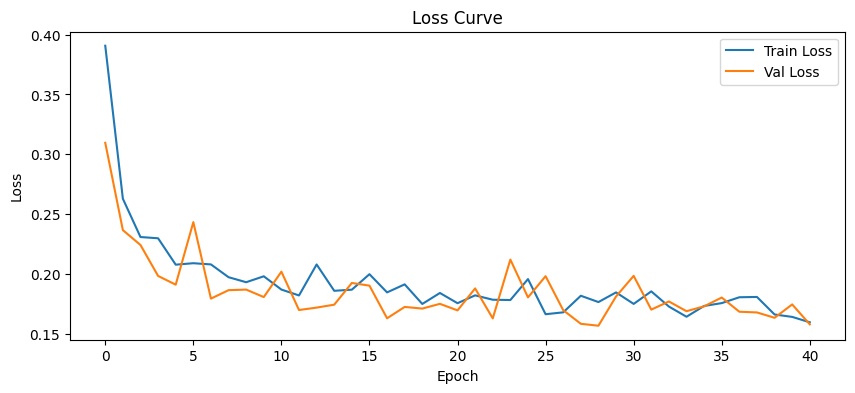

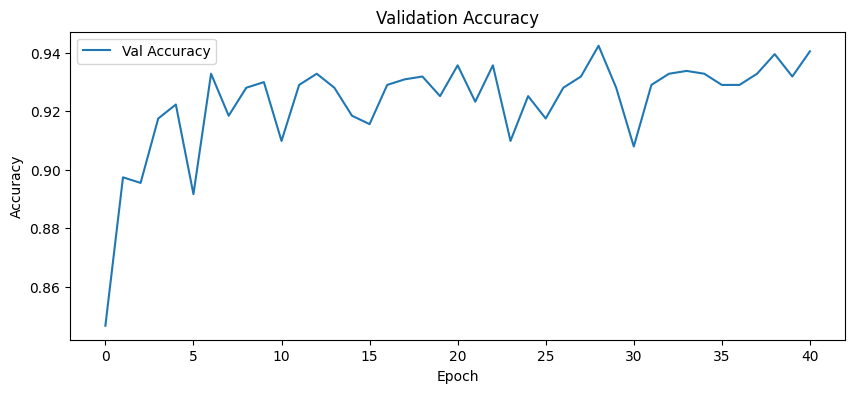

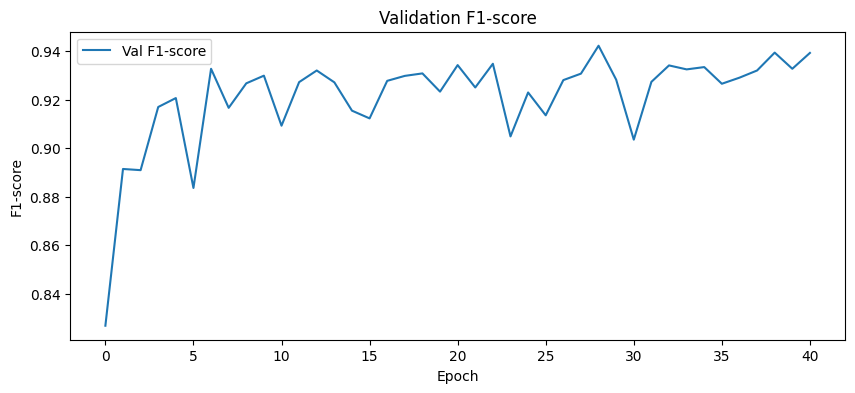

In [27]:
# 1. Loss 그래프
plt.figure(figsize=(10,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 2. Accuracy 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 3. F1-score 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_f1'], label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score')
plt.legend()
plt.show()

In [20]:
pretrained_model_v3_finetunebest_load = model_v3.to(device)
pretrained_model_v3_finetunebest_load.load_state_dict(torch.load('pth/resnet18_fold2_CrossEntropyLoss_20250626_160634_best_epoch016_val0.126289_acc0.9569_f10.9568.pth', map_location=device))
pretrained_model_v3_finetunebest_load.to(device)
pretrained_model_v3_finetunebest_load.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader_v3:
        X, y = X.to(device), y.to(device)
        outputs = pretrained_model_v3_finetunebest_load(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 3. 지표 계산
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.8462
Test F1-score: 0.8384
Confusion Matrix:
[[149  85]
 [ 11 379]]


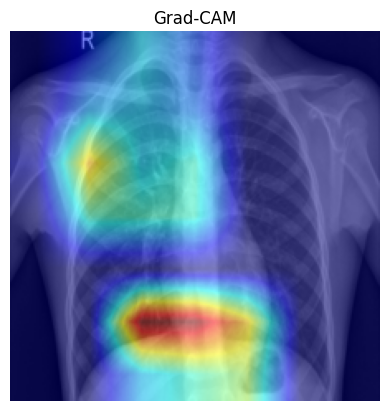

In [26]:
# 1. 모델 준비 (이미 학습된 모델 불러오기)
pretrained_model_v3_finetunebest_load.eval()

# 2. Grad-CAM 객체 생성 (마지막 conv layer 지정)
target_layer = pretrained_model_v3_finetunebest_load.layer4[-1]  # ResNet18의 마지막 conv block
cam = GradCAM(model=pretrained_model_v3_finetunebest_load, target_layers=[target_layer])

# 3. 테스트 이미지 1장 불러오기
img_tensor, label = test_dataset_v3[0]  # (C, H, W), torch.Tensor
input_tensor = img_tensor.unsqueeze(0).to(device)  # 배치 차원 추가

# 4. CAM 생성
grayscale_cam = cam(input_tensor=input_tensor)[0]  # (H, W), numpy

# 5. 원본 이미지로 변환
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # 0~1 정규화

# 6. CAM 시각화
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

### FP / FN 케이스 시각화

오탐(False Positive, FP): 실제는 정상(0)인데 폐렴(1)으로 예측한 경우

미탐(False Negative, FN): 실제는 폐렴(1)인데 정상(0)으로 예측한 경우

In [30]:
pretrained_model_v3_finetunebest_load.eval()
all_images, all_labels, all_preds = [], [], []

with torch.no_grad():
    for images, labels in test_loader_v3:
        images = images.to(device)
        outputs = pretrained_model_v3_finetunebest_load(images)
        _, preds = torch.max(outputs, 1)
        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())

all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

# 오탐/미탐 인덱스
fp_idx = (all_labels == 0) & (all_preds == 1)  # False Positive
fn_idx = (all_labels == 1) & (all_preds == 0)  # False Negative

fp_images = all_images[fp_idx]
fn_images = all_images[fn_idx]

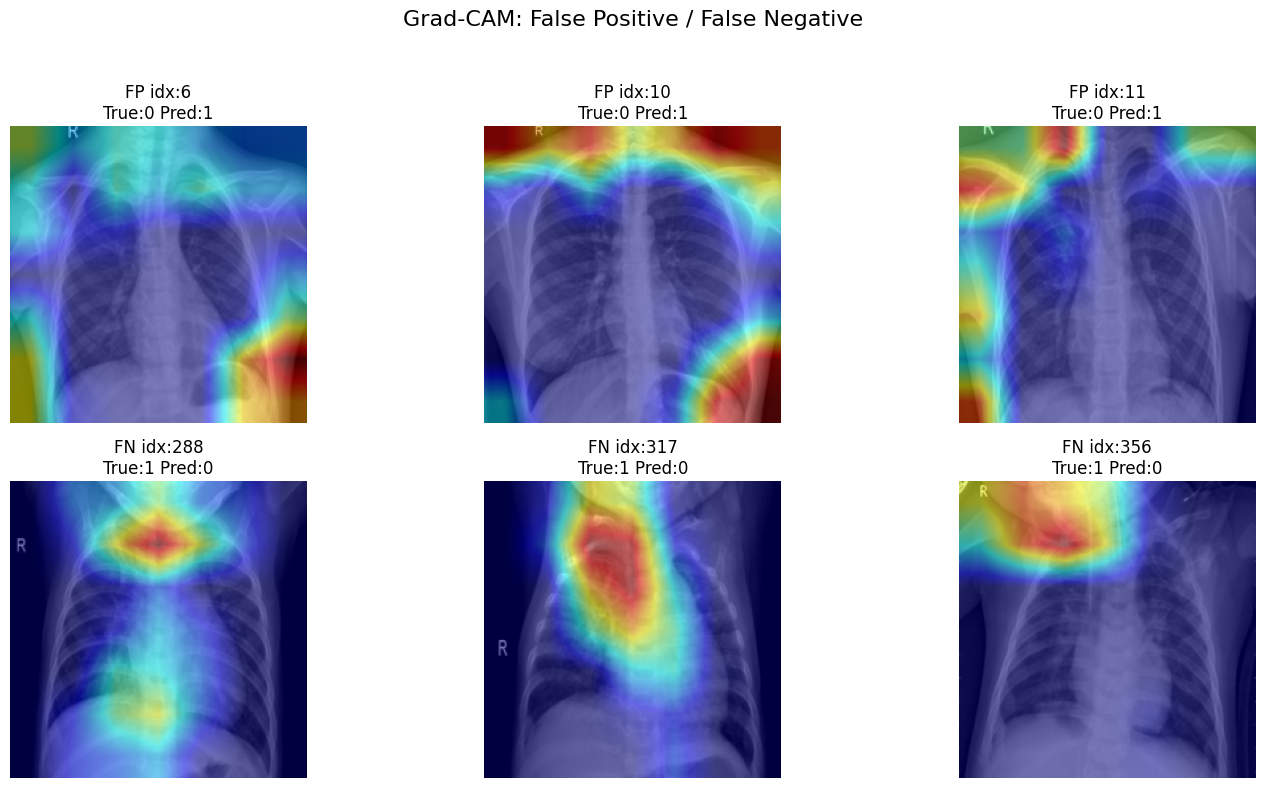

In [35]:
fp_indices = torch.where(fp_idx)[0][:3]
fn_indices = torch.where(fn_idx)[0][:3]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Grad-CAM: False Positive / False Negative", fontsize=16)

# 오탐(FP) subplot
for i, idx in enumerate(fp_indices):
    input_tensor = all_images[idx].unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor)[0]
    img = all_images[idx].numpy().transpose(1,2,0)
    img = (img - img.min()) / (img.max() - img.min())
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    axes[0, i].imshow(visualization)
    axes[0, i].set_title(f"FP idx:{idx.item()}\nTrue:0 Pred:1")
    axes[0, i].axis('off')

# 미탐(FN) subplot
for i, idx in enumerate(fn_indices):
    input_tensor = all_images[idx].unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor)[0]
    img = all_images[idx].numpy().transpose(1,2,0)
    img = (img - img.min()) / (img.max() - img.min())
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    axes[1, i].imshow(visualization)
    axes[1, i].set_title(f"FN idx:{idx.item()}\nTrue:1 Pred:0")
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()